In [1]:
from src.neural_networks.get_data import get_tf_data, stack_1d_features, normalize_1d_features_with_mean_std, load_cv_data
from src.neural_networks.nn_forecast import NNForecast
from src.visualization.twcrpss_plot import make_twcrpss_plot_tf
from src.visualization.brier_score import make_brier_skill_plot_tf
from src.visualization.pit import make_cpit_diagram_tf, comp_multiple_pit_scores
from src.visualization.reliability_diagram import make_reliability_and_sharpness_tf
from src.training.training import load_model
from src.visualization.plot_forecasts import plot_forecast_pdf_tf
from src.climatology.climatology import Climatology
from src.visualization.brier_score import get_brier_scores_tf


import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

2024-05-22 13:04:16.623737: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-22 13:04:16.626126: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-22 13:04:16.658186: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-22 13:04:19.637428: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
features_names = ['wind_speed', 'press', 'kinetic', 'humid', 'geopot']

features_names_dict = {name: 1 for name in features_names}

features_names_dict['wind_speed'] = 15

ignore = ['229', '285', '323']

In [4]:
train_data_original, test_data, data_info = load_cv_data(3, features_names_dict)

train_data = train_data_original.shuffle(len(train_data_original))

train_data = train_data.batch(32)

train_data = train_data.prefetch(tf.data.experimental.AUTOTUNE)

In [5]:
test_data_original = test_data

In [6]:
def filter_func(features, label, threshold):
    return tf.reduce_all(label > threshold)


test_data_greater_17 = test_data_original.filter(lambda features, label: filter_func(features, label, 17))

test_data_greater_15 = test_data_original.filter(lambda features, label: filter_func(features, label, 15))

test_data_greater_13 = test_data_original.filter(lambda features, label: filter_func(features, label, 13))

In [7]:
# Define the generator function
def data_generator(data_list):
    for sample, y in data_list:
        # Convert each dictionary in sample to a tuple of tensors
        yield ({k: tf.convert_to_tensor(v) for k, v in sample.items()}, tf.convert_to_tensor(y))

# Prepare your data
test_data_17_list = list(test_data_greater_17.as_numpy_iterator())

# Define the output signature for the dataset
output_signature = (
    {
        'station_code': tf.TensorSpec(shape=(), dtype=tf.string),
        'features_1d': tf.TensorSpec(shape=(4,), dtype=tf.float32),
        'features_emos': tf.TensorSpec(shape=(5,), dtype=tf.float32),
        'wind_speed_grid': tf.TensorSpec(shape=(15, 15, 1), dtype=tf.float32),
        'wind_speed_forecast': tf.TensorSpec(shape=(), dtype=tf.float32)
    },
    tf.TensorSpec(shape=(), dtype=tf.float32)
)

# Create the dataset
test_data_greater_17 = tf.data.Dataset.from_generator(
    lambda: data_generator(test_data_17_list),
    output_signature=output_signature
)




2024-05-22 13:04:40.914922: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [8]:
test_data_greater_17 = test_data_greater_17.batch(10000)

# test_data_greater_17 = test_data_greater_17.repeat()

X, y = next(iter(test_data_greater_17))

print(y.shape)



(31,)


In [9]:
test_data = test_data.batch(len(test_data))

test_data = test_data.repeat()

test_data = test_data.prefetch(tf.data.experimental.AUTOTUNE)

In [10]:
folder = '/net/pc200239/nobackup/users/hakvoort/models/climatology/climatology_cv_3'

climatology = Climatology.load(folder)

In [11]:
filepath = '/net/pc200239/nobackup/users/hakvoort/models/conv_nn/'

nn_crps = NNForecast.my_load(filepath + 'CRPS_trunc_normal_epochs_10', train_data)

nn_crps_epochs_200 = NNForecast.my_load(filepath + 'CRPS_trunc_normal_epochs_200', train_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 946ms/step


/usr/people/hakvoort/.local/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 142 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 894ms/step


In [12]:
filepath = '/net/pc200239/nobackup/users/hakvoort/models/emos/batching/'

emos_crps = load_model(filepath + 'crps_batch_none_epochs_600')

Using given parameters for Truncated Normal distribution


In [37]:
models = {'nn_crps': nn_crps, 'emos_crps': emos_crps, 'nn_crps_epochs_200': nn_crps_epochs_200}

best_models = {'nn_crps': nn_crps, 'emos_crps': emos_crps}

244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


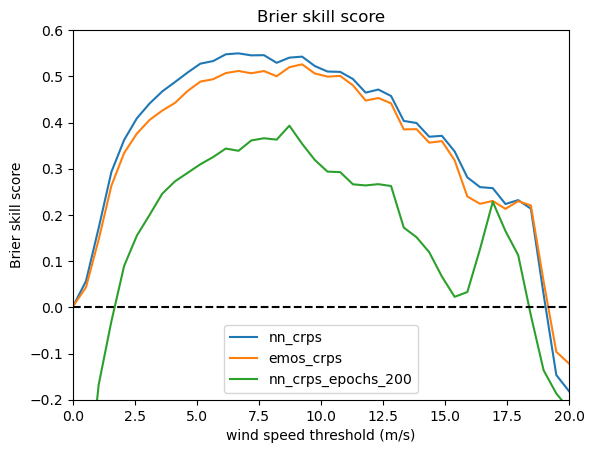

In [93]:
values = np.linspace(0.01, 20, 200)
values = np.linspace(0.01, 20, 40)
ylim = [-0.2, 0.6]
make_brier_skill_plot_tf(climatology, models, test_data, values, ylim=ylim)

244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


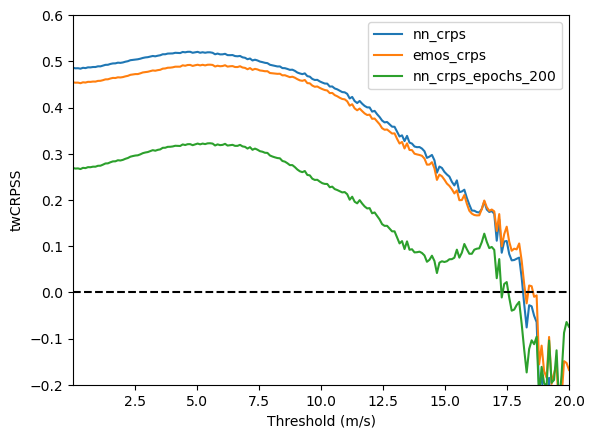

In [ ]:
sample_size = 10000
ylim = [-0.2, 0.6]
make_twcrpss_plot_tf(climatology, models, test_data, values, ylim=ylim, sample_size=sample_size)

In [149]:
X, y = next(iter(test_data_greater_17))
print(y.shape)

#y_pred = nn_crps.predict(X)

()


In [33]:
print('CRPS of nn_crps:', nn_crps.CRPS(test_data, 10000).numpy())
print('CRPS of elements greater than 17:', nn_crps.CRPS(test_data_greater_17, 10000).numpy())
print('CRPS of climatology: ', climatology.get_twCRPS(test_data, [0], 10000))
print('CRPS of elements greater than 17:', climatology.get_twCRPS(test_data_greater_17, [0], 10000))
print('CRPS of EMOS: ', emos_crps.CRPS_tfdataset(test_data, 10000).numpy())
print('CRPS of elements greater than 17:', emos_crps.CRPS_tfdataset(test_data_greater_17, 10000).numpy())
#print('CRPS of elements greater than 15:', nn_crps.CRPS(test_data_greater_15, 10000).numpy())
#print('CRPS of elements greater than 13:', nn_crps.CRPS(test_data_greater_13, 10000).numpy())

244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
CRPS of nn_crps: 0.83738655
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
CRPS of elements greater than 17: 2.0195484
CRPS of climatology:  [1.62555886]
CRPS of elements greater than 17: [8.93879202]
CRPS of EMOS:  0.8882097
CRPS of elements greater than 17: 2.1539369


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


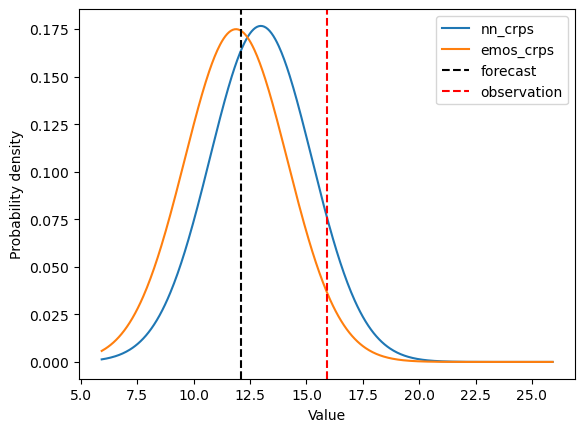

In [91]:
t = 15
plot_forecast_pdf_tf(best_models, test_data_original, observation_value=t, plot_size= 10)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


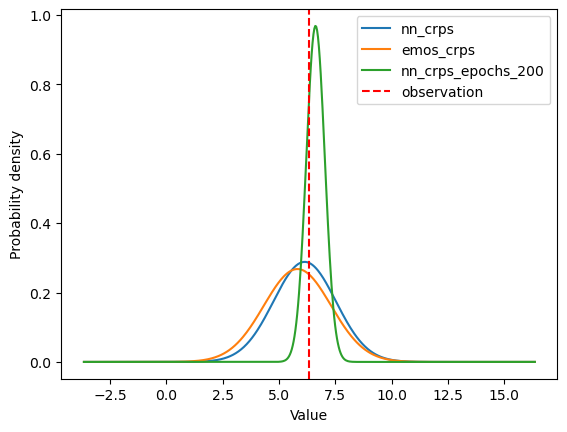

In [47]:
t = 0
plot_forecast_pdf_tf(models, train_data_original, observation_value=t, plot_size= 10)